# DNA standards

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob

In [82]:
per_base = df[df["filter"].isin(("OK", "no_pT" if not pt_len else ""))].per_base.mean(); per_base

2.294998858186801

In [83]:
*df[df["filter"].isin(("OK", "no_pT" if not pt_len else ""))].per_base/per_base

11       0.827887
18       1.525055
20       1.176471
22       1.307190
24       1.002179
           ...   
33582    0.784314
33583    0.697168
33588    0.915033
33589    0.871460
33590    0.610022
Name: per_base, Length: 21895, dtype: float64

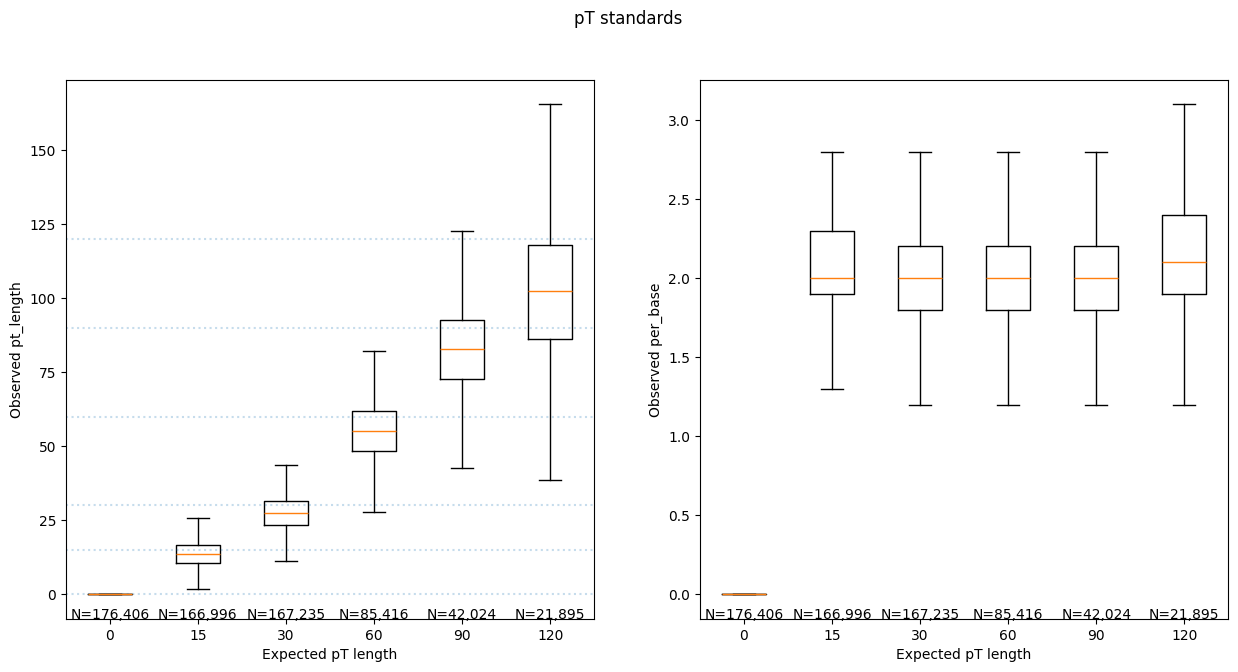

In [88]:
y = "pt_length"
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sel = df["filter"].isin(("OK", "no_pT" if not pt_len else ""))
    sizes = df.loc[sel, y].to_numpy()
    #sizes = df.loc[sel, y].to_numpy() * df[sel].per_base/df[sel].per_base.mean()
    data.append(sizes)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax = axes[0]
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y}"); 
fig.suptitle("pT standards")

y = "per_base"
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sizes = df.loc[df["filter"].isin(("OK", "no_pT" if not pt_len else "")), y].to_numpy()
    data.append(sizes)

ax = axes[1]
#fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y}"); 
#ax.set_title("pT standards")
fig.savefig("pt_standards.pdf")

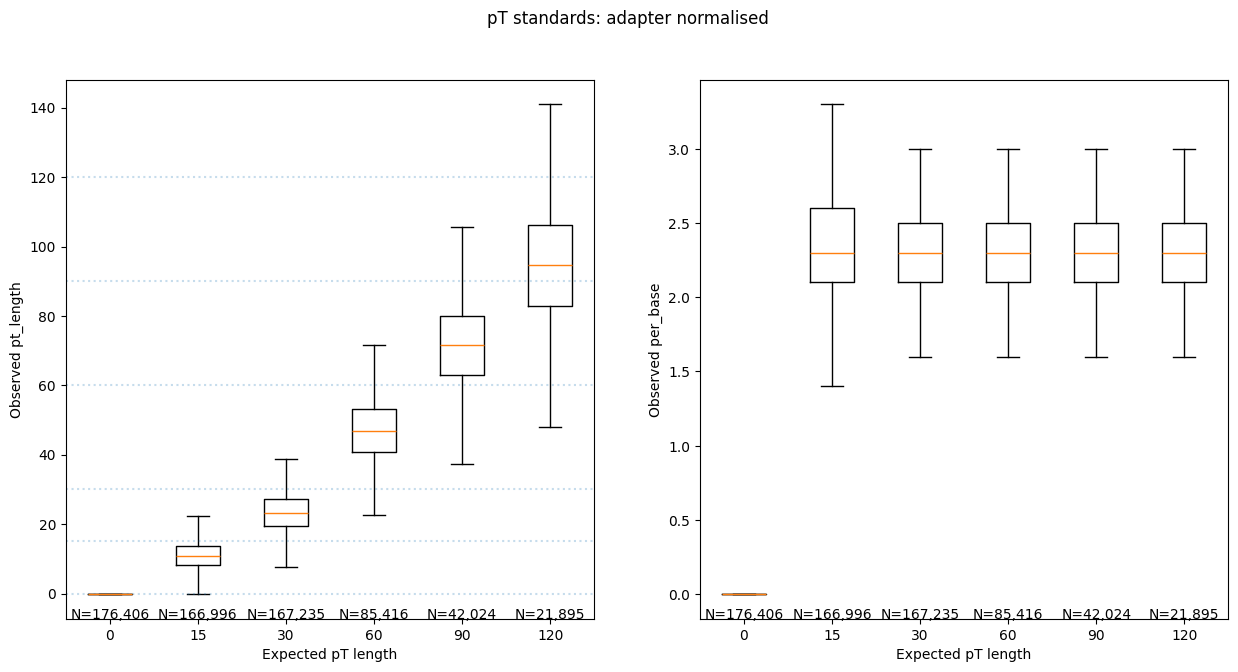

In [89]:
y = "pt_length"
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards.adapter_norm/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sel = df["filter"].isin(("OK", "no_pT" if not pt_len else ""))
    sizes = df.loc[sel, y].to_numpy()
    #sizes = df.loc[sel, y].to_numpy() * df[sel].per_base/df[sel].per_base.mean()    
    data.append(sizes)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax = axes[0]
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y}"); 
fig.suptitle("pT standards: adapter normalised")

ax = axes[1]
y = "per_base"
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards.adapter_norm/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sizes = df.loc[df["filter"].isin(("OK", "no_pT" if not pt_len else "")), y].to_numpy()
    data.append(sizes)

_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y}"); 
fig.savefig("pt_standards.adapter_normalised.pdf")

Text(0.5, 1.0, 'pT standards: adapter normalised')

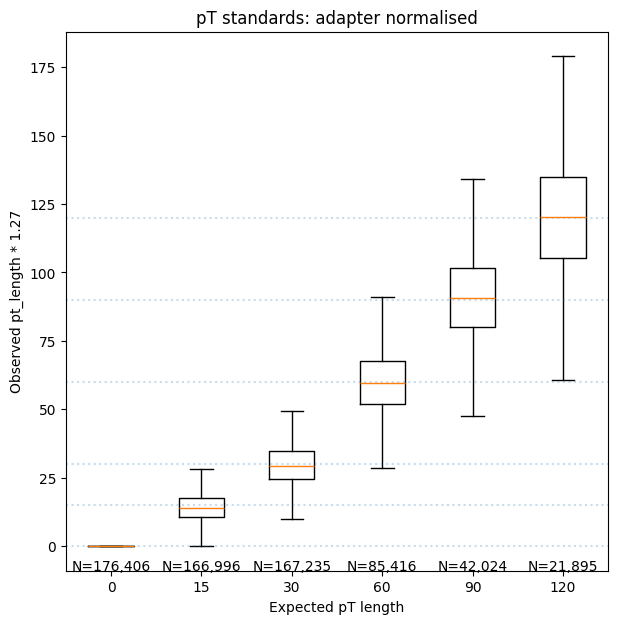

In [75]:
y = "pt_length"
norm = 1.27
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards.adapter_norm/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sizes = df.loc[df["filter"].isin(("OK", "no_pT" if not pt_len else "")), y].to_numpy() * norm
    data.append(sizes)

fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y} * {norm}"); 
ax.set_title("pT standards: adapter normalised")

Text(0.5, 1.0, 'pT standards')

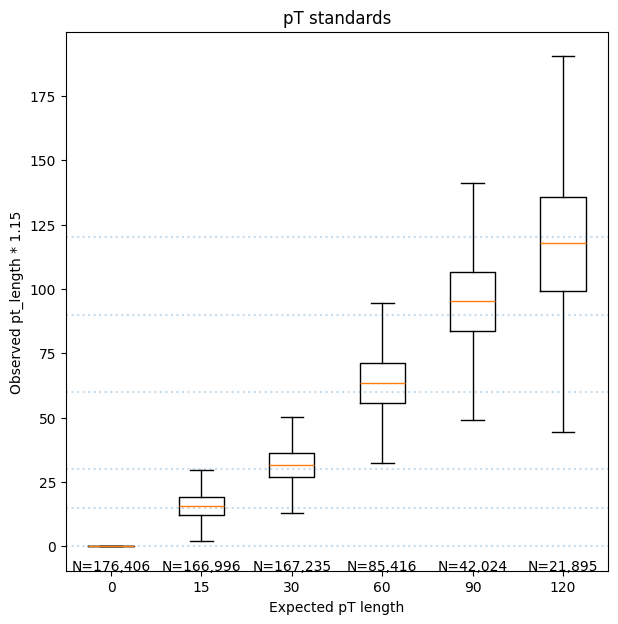

In [78]:
y = "pt_length"
norm = 1.15
data = []
fn = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/R10_DNA_Standards/N3PS_R10_DNAStd_DoradoSUP_%sA.bam.tsv"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t")
    sizes = df.loc[df["filter"].isin(("OK", "no_pT" if not pt_len else "")), y].to_numpy() * norm
    data.append(sizes)

fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y} * {norm}"); 
ax.set_title("pT standards")


### debug standards

In [168]:
import os, sys
sys.path.append('/home/lpryszcz/cluster/rna_mods/N3Pseq/src/')
from get_pT import alg2pt

primer = "CAGCACCT"+"ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG"+"TTT"
minscore=20
scoring=(2, 3, 3, 2)
match_score, mismatch_penalty, open_penalty, extend_penalty = scoring
matrix = parasail.matrix_create("ACGT", match_score, -mismatch_penalty)
profile = parasail.profile_create_16(primer, matrix)

import pysam
bam = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_30A.bam"
sam = pysam.AlignmentFile(bam)
for a in sam: 
    if a.flag&2308: continue
    info, pt_len, per_base, pt_start, before_seq, pt_seq = alg2pt(a, primer, profile, open_penalty, extend_penalty)
    if info!="OK": continue
    break

In [169]:
info, pt_len, per_base, pt_start, before_seq, pt_seq

('OK', 65.8, 1.9271899886234358, 108, 'AGCAGAGTCT', 'TTTTTTTTCTT')

In [170]:
a.get_forward_sequence()

'TTTTGTGGCGCCTTTCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACCTACTTGCCTGTCGCTCTATCTGCAGAGCAGAGTCTTTTTTTTTCTTGGTTTCCTGTTTTCAAAGGGCCGTCAGTCCGGGGCGTTTGGTTACTTACCGGTCGAGGTTTTCTATATATTAAACCCTATCTCATTGCGTAGCTATTTATGTTATTGTTAACTTGTGGCGTTGGAGATAAATGGTAATCTATCAGTTAGTCTGCTTAAGTCTATAGGGTTAATTATTTACATGCTGTGTCTGTATTTACGGCTATCCATGTGATGCAGTGATCTAGATTGGGTGTGTTGCGTTTTCGCCTTTGTTCGCACGCATCCTACACCGCTTCGATTAAAATCTTCTCTTATTTTCTTTAACCGTTGGCATTTTGGAGAAACTGTGTTGTGTCAACGGCTCTGGCAGTTCTAATCTTTTTTTTGTCCGGTGCACCGATTGGCTGTTTTAGCTCATTGTGACGTGAGTTGATACGGTGTCATACAACGTGTCGATTGGTCATCTATTCGTTATCAGCTTCTTAACCCCCTTACAGGTCAAGGCTTATACCATCATGCTCTCAGATTGTTCTGTACCTTCATTCTTGACTCGGTTTAATTTTGTTCGATCCTATTCTGTGAACAACATGGGTTGCTTTTGAAGGCCGGAATGTAGCTTACGCATCACTCTTCTTCATACTCCGGTTAAGCTTTAATGCTTGCTGTGGGATGTAGACACTTACTCTCTGTGTGTAGTTTCCCCATCTCACTCCATTCACGTTGCTCAGTCTCAGTCCGTTCTTTTGTTATGATAATCTTCGTGGATATTGTTTTTGACTTCATTAATCTCTGTTCTGGATTGCTCTACCTCAAATGCACTGTGACGGTGTCCTCTATAGTCCTCATTCCTATCACCCTAGCTTTCTTCACCAATTTGGCCTAGTATCCAGTCGGGGTAG

In [173]:
tags = {k: v for k, v in a.tags}
mv = np.array(tags['mv'])
stride, move = mv[0], mv[1:]
move_pos = np.argwhere(move==1).flatten()
steps = move_pos[1:]-move_pos[:-1]

In [183]:
extension = 5
s = pt_start
e = s+len(pt_seq)
steps[s-extension:e+extension+1].sum() / per_base - 2*extension, steps[s-extension:e+extension+1]

(65.75796930342385,
 array([ 4,  4,  1,  3,  2, 34, 11,  9,  4, 14, 42,  2,  1,  3,  2,  1,  1,
         2,  1,  1,  1,  3]))

In [187]:
steps[s-extension:e+extension+1].sum()/((steps[:s-extension].mean()+steps[e+extension+1:].mean())/2

16.690322987954243